In [89]:
#Import libraries
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn

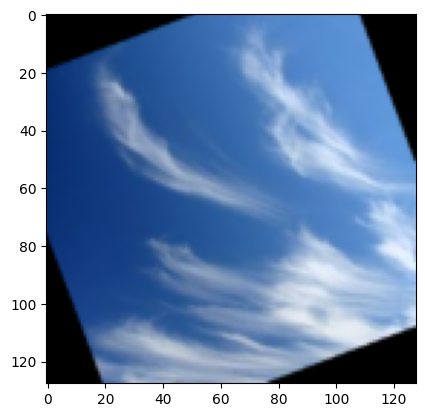

In [90]:
train_transforms = transforms.Compose([
    # Add horizontal flip and rotation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "data_clouds/clouds_train",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

In [91]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [93]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

dataset_train = ImageFolder(
  "data_clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

In [95]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.9251
Epoch 2, Loss: 1.5569
Epoch 3, Loss: 1.4268


In [96]:
dataset_test = ImageFolder(
  "data_clouds/clouds_test",
  transform=train_transforms,
)
dataloader_test = DataLoader(
  dataset_train, shuffle=True, batch_size=16)

In [99]:
from torchmetrics import Recall, Precision
#Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average=None)
metric_recall = Recall(task='multiclass', num_classes=7, average=None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: tensor([0.0000, 0.4660, 0.6000, 0.7419, 0.4262, 0.5667, 0.3500])
Recall: tensor([0.0000, 0.8000, 0.6429, 0.2527, 0.7820, 0.6939, 0.1148])


In [100]:
#Analyzing metrics per class

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)

{'cirriform clouds': 0.0, 'clear sky': 0.4660194218158722, 'cumulonimbus clouds': 0.6000000238418579, 'cumulus clouds': 0.7419354915618896, 'high cumuliform clouds': 0.4262295067310333, 'stratiform clouds': 0.5666666626930237, 'stratocumulus clouds': 0.3499999940395355}
